In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2

In [227]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)

In [210]:
df = pd.read_excel('data/rpsp1.xlsx', sheet_name='Sheet1')
df.head()

,choice,Gender,Income,Driving-years,Purpose,Duration,Fee,Walking-distance,Rent-or-not,Parking-time-limited,Information of free parking is not released timely,Vehicle-safety,Others,total
0,normal parking slot,2,3,1,3,3,2,1,1,3,2,4,2,11
1,shared parking slot,2,4,2,1,4,3,2,2,3,4,3,3,13
2,normal parking slot,2,4,1,1,3,3,1,1,3,4,4,3,14
3,shared parking slot,2,2,1,1,1,2,2,3,4,4,3,2,13
4,shared parking slot,1,2,1,3,4,4,2,1,3,2,2,1,8


In [211]:
dummies = pd.get_dummies(df['choice'], prefix='choice', drop_first=False)
df = pd.concat([df, dummies], axis=1)
df = df.drop(['choice'], axis=1)

In [112]:
X = df.drop(['choice_normal parking slot','choice_shared parking slot'],axis=1)
y = df[['choice_shared parking slot']].copy()

In [164]:
y.head()

,choice_shared parking slot
0,0
1,1
2,0
3,1
4,1


In [166]:
X.head()

,Gender,Income,Driving-years,Purpose,Duration,Fee,Walking-distance,Rent-or-not,Parking-time-limited,Information of free parking is not released timely,Vehicle-safety,Others,total
0,2,3,1,3,3,2,1,1,3,2,4,2,11
1,2,4,2,1,4,3,2,2,3,4,3,3,13
2,2,4,1,1,3,3,1,1,3,4,4,3,14
3,2,2,1,1,1,2,2,3,4,4,3,2,13
4,1,2,1,3,4,4,2,1,3,2,2,1,8


# Recursive Feature Elimination

In [170]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

y1 = np.array(y)
y1 = y1.reshape(y1.shape[0])
y1.shape

rfe = RFE(logreg, 4)
rfe = rfe.fit(X,y1)
print(rfe.support_)
print(rfe.ranking_)

for i,bol in enumerate(rfe.support_):
    if bol:
        print(X.columns[i])

[ True False False False  True False  True False  True False False False
 False]
[ 1  8  2  4  1  9  1  5  1 10  3  7  6]
Gender
Duration
Walking-distance
Parking-time-limited


# Result of RFE
## From the above results the selected column are:
<br>
<ul>
<li>Gender</li>
<li>Duration</li>
<li>Walking-distance</li>
<li>Parking-time-limited</li>
</ul>

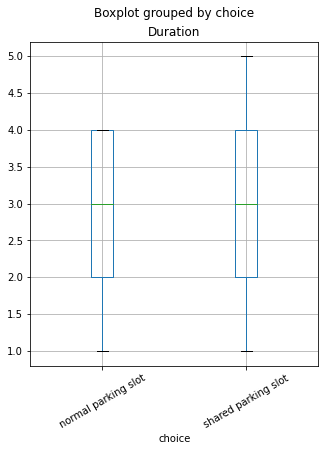

In [45]:
df.boxplot('Duration','choice',rot = 30,figsize=(5,6))

(248,)

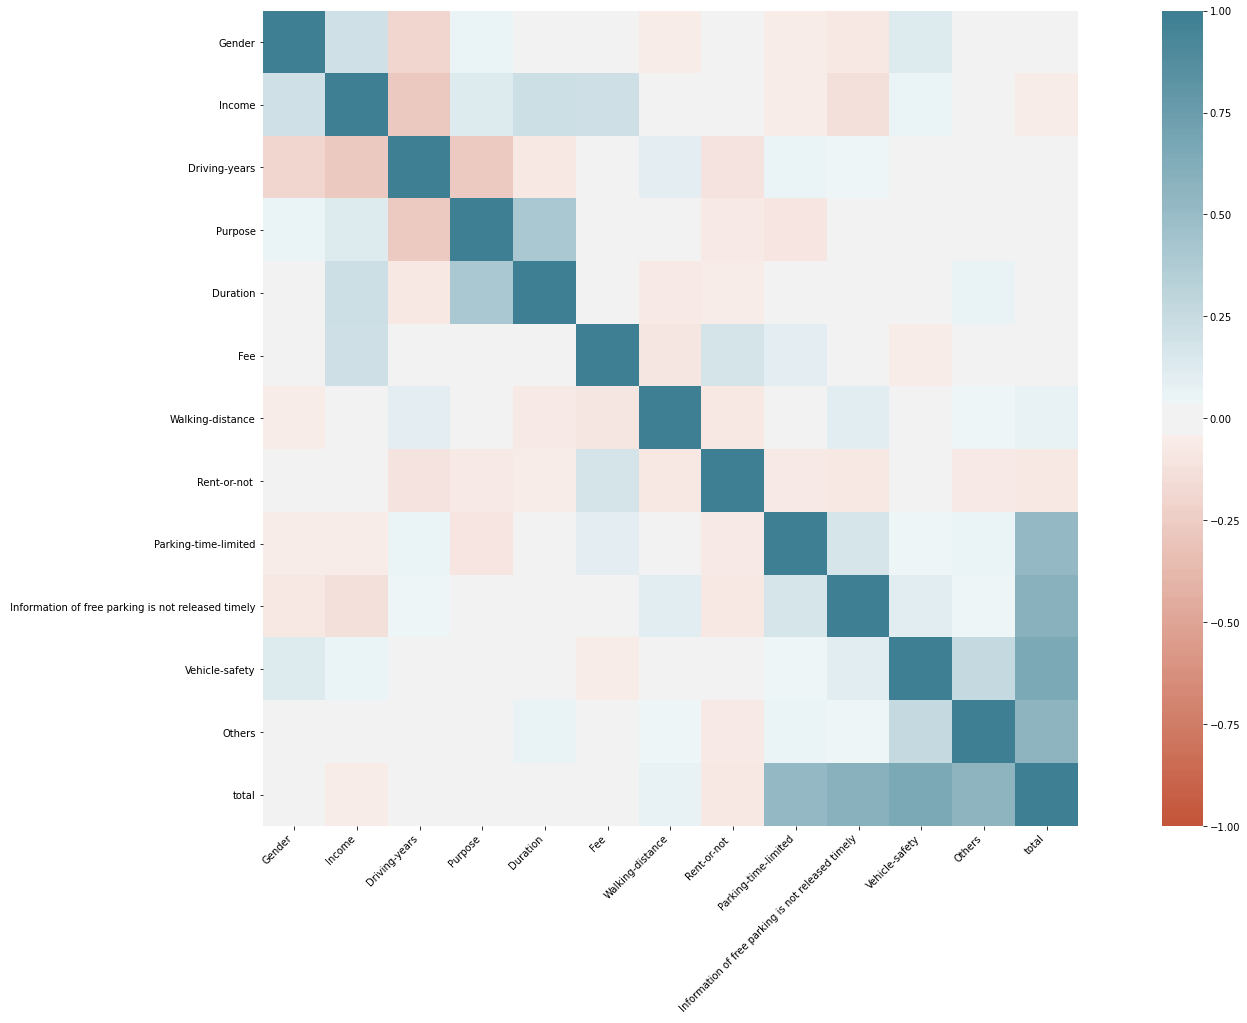

In [48]:
plt.figure(figsize=(30, 15))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.savefig("heatmap.jpg")

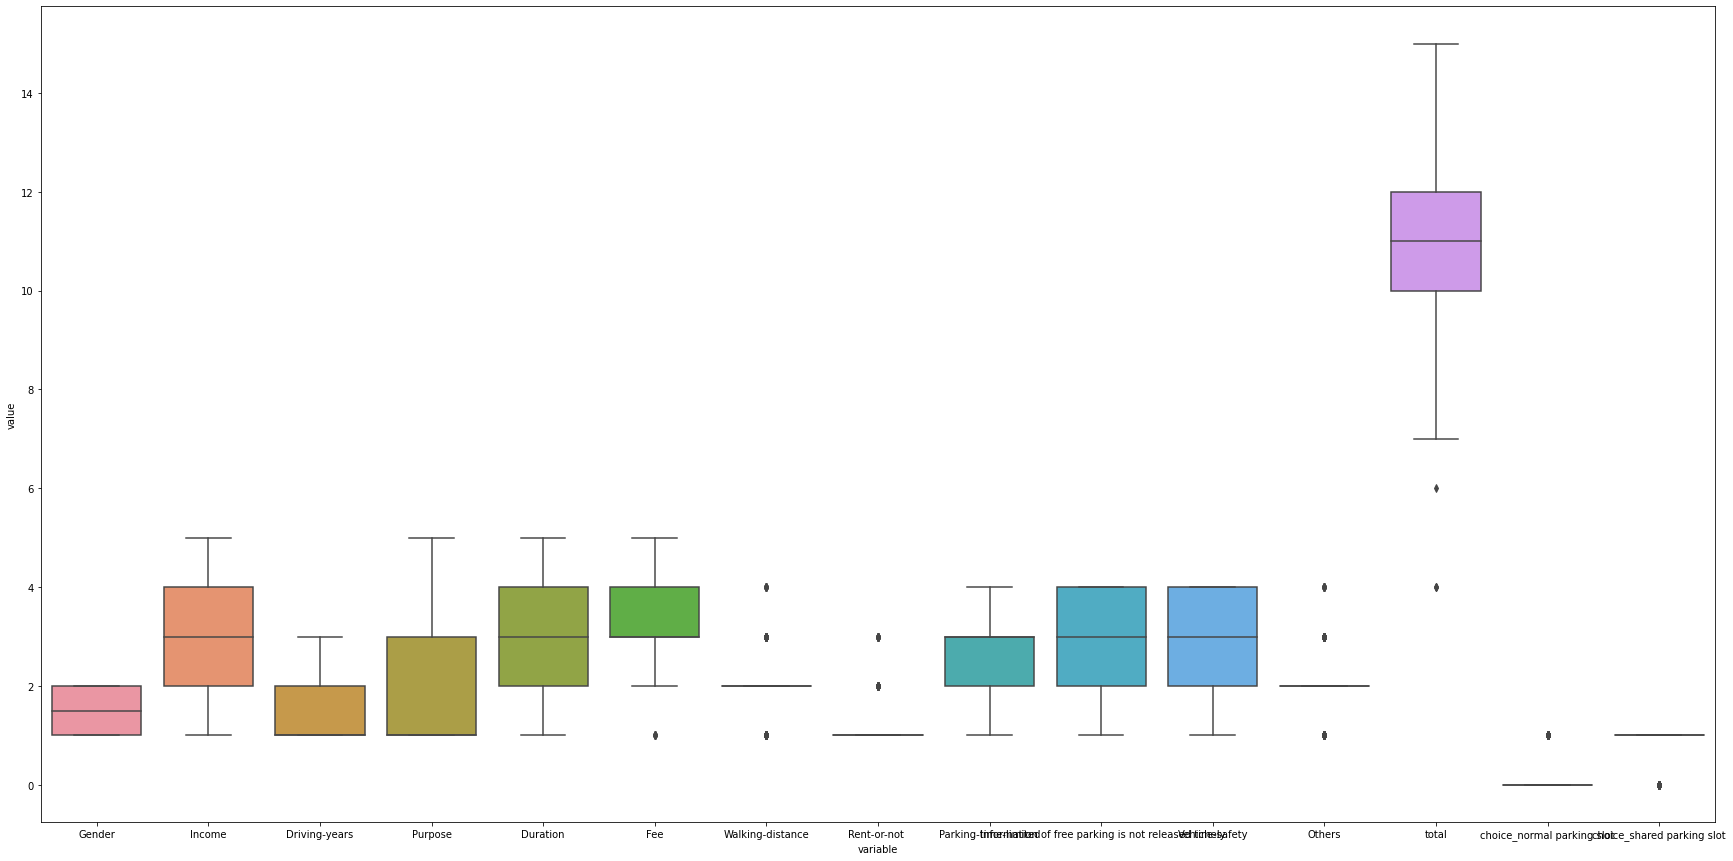

In [103]:
plt.figure(figsize=(30, 15))
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.savefig('combine_boxplot_without_time.jpg')

plt.show()

<Figure size 2160x1080 with 0 Axes>

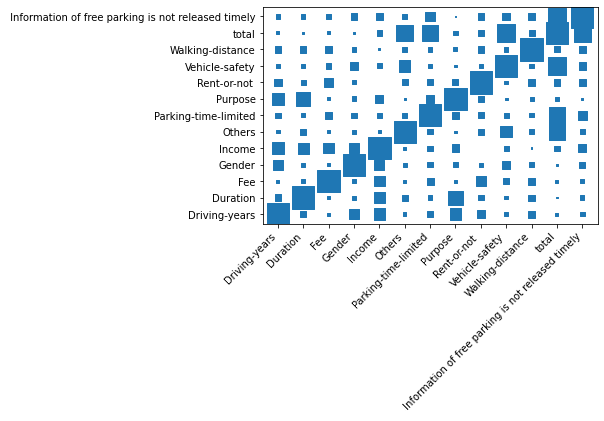

In [51]:
# Step 1 - Make a scatter plot with square markers, set column names as labels
plt.figure(figsize=(30, 15))
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
corr = df.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)
plt.savefig("box_heatmap.png")

# Spearman's Rank Correlation
## Not beneficial , coefficiants are too small

In [80]:
corr = df.corr(method='spearman')
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

table = pd.pivot_table(corr, values='value', index=['x'],
                    columns=['y'], aggfunc=np.sum)

In [221]:
spearman_coeff = table[['choice_shared parking slot']]
spearman_coeff = pd.DataFrame(spearman_coeff['choice_shared parking slot'])
spearman_coeff.iloc[:,0].abs().nlargest(6)

x
choice_normal parking slot    1.000000
choice_shared parking slot    1.000000
Walking-distance              0.162607
Duration                      0.083226
Parking-time-limited          0.059089
Vehicle-safety                0.051446
Name: choice_shared parking slot, dtype: float64

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


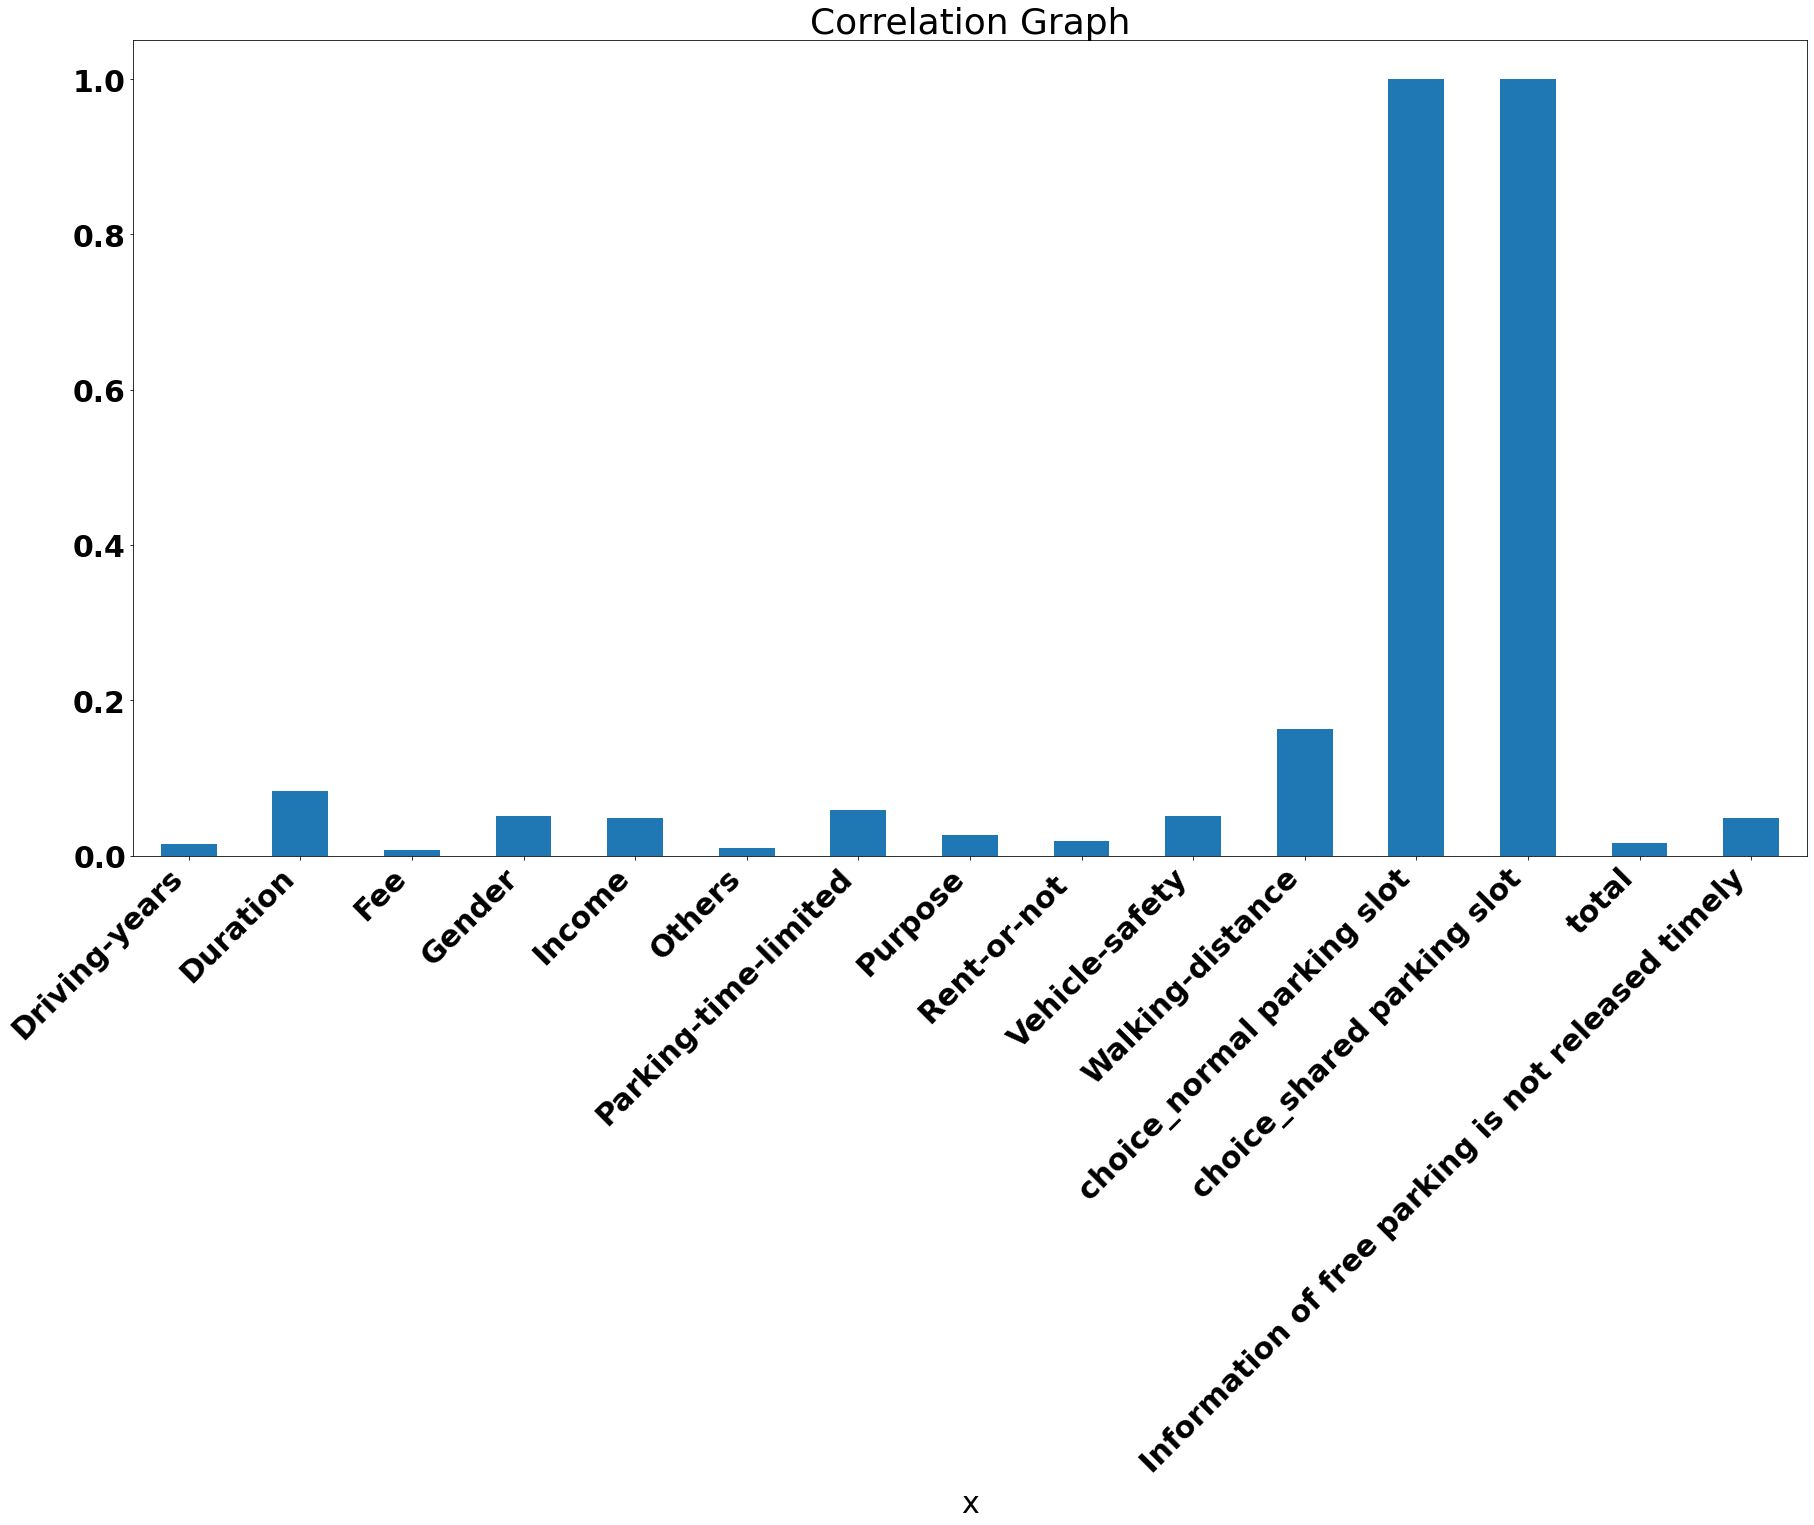

In [229]:
plt.figure(figsize=(30, 15))
plt.title("Correlation Graph")
corr = df.corr()
ax = spearman_coeff.iloc[:,0].abs().plot.bar(x='lab', y='val', rot=0)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.savefig("heatmap.jpg")


# Result of Spearman 
## the co-efficients are very low but the variables with largest correlation are
<br>
<ul>
<li>Walking-distance</li>
<li>Duration</li>
<li>Parking-time-limited</li>
<li>Vehicle-safety</li>
</ul>

# Chi-Square Test

In [83]:
def check_categorical_dependency(crosstab_table, confidence_interval):
    stat, p, dof, expected = stats.chi2_contingency(crosstab_table)
    print ("Chi-Square Statistic value = {}".format(stat))
    print ("P - Value = {}".format(p))
    alpha = 1.0 - confidence_interval
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    return expected

In [208]:
df

,choice,Gender,Income,Driving-years,Purpose,Duration,Fee,Walking-distance,Rent-or-not,Parking-time-limited,Information of free parking is not released timely,Vehicle-safety,Others,total
0,normal parking slot,2,3,1,3,3,2,1,1,3,2,4,2,11
1,shared parking slot,2,4,2,1,4,3,2,2,3,4,3,3,13
2,normal parking slot,2,4,1,1,3,3,1,1,3,4,4,3,14
3,shared parking slot,2,2,1,1,1,2,2,3,4,4,3,2,13
4,shared parking slot,1,2,1,3,4,4,2,1,3,2,2,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,normal parking slot,1,1,2,1,1,4,2,1,2,4,3,2,11
244,shared parking slot,2,3,1,3,3,4,2,3,2,2,3,3,10
245,shared parking slot,1,2,1,3,3,4,1,1,4,2,1,1,8
246,normal parking slot,2,3,1,4,2,4,2,1,3,3,3,2,11


In [212]:
cross_tables = []
for i in X.columns:
    print(i)
    cross_table = pd.crosstab(df[i], df['choice_shared parking slot'], 
                                      margins=True)
    
    print("--- CROSS TABLE ----")
    print(cross_table)
    cross_tables.append({
        "col":i,
        "table":cross_table
    })
    
    print("--- Chi Square Results")
    check_categorical_dependency(cross_table, 0.8)
    print("\n")

Gender
--- CROSS TABLE ----
choice_shared parking slot   0    1  All
Gender                                  
1                           21  103  124
2                           26   98  124
All                         47  201  248
--- Chi Square Results
Chi-Square Statistic value = 0.6562930030697576
P - Value = 0.9566074697279146
Independent (fail to reject H0)


Income
--- CROSS TABLE ----
choice_shared parking slot   0    1  All
Income                                  
1                            6   30   36
2                            8   51   59
3                           20   64   84
4                            9   40   49
5                            4   16   20
All                         47  201  248
--- Chi Square Results
Chi-Square Statistic value = 2.5550409036775052
P - Value = 0.9900491331960529
Independent (fail to reject H0)


Driving-years
--- CROSS TABLE ----
choice_shared parking slot   0    1  All
Driving-years                           
1                     

In [88]:
exp_table_1 = check_categorical_dependency(gender_table, 0.95)

Chi-Square Statistic value = 0.6562930030697576
P - Value = 0.9566074697279146
Independent (fail to reject H0)


# Feature Selection using Chi-Square

In [113]:
X_new = SelectKBest(chi2, k=4).fit_transform(X, y)

In [114]:
X_new.shape

(248, 4)

In [163]:

for i in range(0,X_new.shape[1]):
    print("\n")
    print(pd.crosstab(np.squeeze(X_new[:,i]), np.squeeze(y)))

    print("\n")



choice_shared parking slot   0   1
row_0                             
1                            6  30
2                            8  51
3                           20  64
4                            9  40
5                            4  16




choice_shared parking slot   0   1
row_0                             
1                            5  49
2                            8  32
3                           19  62
4                           15  49
5                            0   9




choice_shared parking slot   0    1
row_0                              
1                           15   45
2                           30  112
3                            2   33
4                            0   11




choice_shared parking slot   0   1
row_0                             
1                            2   5
2                           13  51
3                           16  66
4                           16  79




## So from the above results the Selected Column are:
<br>
<ul>
<li>Income</li>
<li>Duration</li>
<li>Walking-distance</li>
<li>Information of free parking is not released timely</li>
</ul>